The exercises are prepared by Elena Tiukhova, a PhD researcher at KU Leuven university. For questions/suggestions for improvement, please contact elena.tiukhova@kuleuven.be

Dataset sources: 

https://www.kaggle.com/code/renatevankempen/predicting-clv/data

https://www.kaggle.com/datasets/shrutimechlearn/customer-data

https://www.kaggle.com/code/hendraherviawan/customer-segmentation-using-rfm-analysis-r/data


In [ ]:
import pandas as pd
from scipy.stats import iqr
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import tree

from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans

## Data preprocessing

In [ ]:
data = pd.read_excel("clustering data.xlsx")

In [ ]:
data = data.set_index('CustomerID')

First, we need to check if there are missing values in our dataset.

In [ ]:
data.isnull().sum()

Income               0
Age                 13
Monetary            20
Frequency           18
Recency             20
EmploymentStatus    21
dtype: int64

We can see that Age, Employment status, Monetary, Frequency and Recency columns have missing values. For the categorical variable Employment status, we can replace missing values by the mode value. For the continuous variables (Age, Monetary, Frequency and Recency), we can replace missing values by the median value.

In [ ]:
data['EmploymentStatus'] = data['EmploymentStatus'].fillna(data['EmploymentStatus'].mode()[0])

data['Frequency'] = data['Frequency'].fillna(round(data['Frequency'].median(),0))
data['Recency'] = data['Recency'].fillna(round(data['Recency'].median(),0))
data['Monetary'] = data['Monetary'].fillna(data['Monetary'].median())
data['Age'] = data['Age'].fillna(round(data['Age'].median(),0))
data['Income'] = data['Income'].fillna(round(data['Income'].median(),0))

In [ ]:
data.isnull().sum()

Income              0
Age                 0
Monetary            0
Frequency           0
Recency             0
EmploymentStatus    0
dtype: int64

In [ ]:
data.describe()

Income          Age       Monetary   Frequency     Recency
count     500.000000   500.000000     500.000000  500.000000  500.000000
mean    17875.654000    75.196000    2598.698000    4.446000  110.814000
std     22600.827874   446.072899    7471.199845   10.948371  100.722159
min      5090.000000  -500.000000      38.100000    1.000000   22.000000
25%     10960.525000    38.000000     430.547500    1.000000   39.000000
50%     14171.310000    56.000000     977.800000    2.000000   66.000000
75%     17810.897500    76.000000    2374.897500    5.000000  152.250000
max    387482.590000  9999.000000  124914.530000  210.000000  395.000000

From the desriptive statistics, we can see that there are irrelevant age values (min of -500 and max of 9999). These values are obvious outliers. The negative age values are not realistic and we can impute them with the minimal value of the age variable. For the positive values of the Age variable, we can detect outliers by employing robust z-scores. The observations that have robust z-scores for the Age variable greater than 3 can be considered outliers. We can replace outliers with the robust z-score higher than 3 with the value of median + 3*IQR.

In [ ]:
data['Age: robust z-score'] = (data['Age'] - data['Age'].median())/iqr(data['Age'])
data['Age'] = np.where((data['Age: robust z-score'] > 3),data['Age'].median() + 3*iqr(data['Age']),data['Age'])
data['Age'] = np.where((data['Age'] < 0),data[data['Age'] > 0]['Age'].min(),data['Age'])

We can also check other variables for the outliers using the same approach of robust z-scores. From the descriptive statistics, we can see that these columns do not have negative values, and any positive value is relevant except of extremely high values. These extreme cases can be signified by robust z-scores higher than 3 and replaced with the value of median + 3*IQR.

In [ ]:
data['Income: robust z-score'] = (data['Income'] - data['Income'].median())/iqr(data['Income'])
data['Income'] = np.where((data['Income: robust z-score'] > 3),
                                 data['Income'].median() + 3*iqr(data['Income']),data['Income'])

data['Monetary: robust z-score'] = (data['Monetary'] - data['Monetary'].median())/iqr(data['Monetary'])
data['Monetary'] = np.where((data['Monetary: robust z-score'] > 3),
                                 data['Monetary'].median() + 3*iqr(data['Monetary']),data['Monetary'])

data['Frequency: robust z-score'] = (data['Frequency'] - data['Frequency'].median())/iqr(data['Frequency'])
data['Frequency'] = np.where((data['Frequency: robust z-score'] > 3),
                                 round(data['Frequency'].median() + 3*iqr(data['Frequency']),0),data['Frequency'])

data['Recency: robust z-score'] = (data['Recency'] - data['Recency'].median())/iqr(data['Recency'])
data['Recency'] = np.where((data['Recency: robust z-score'] > 3),
                                 round(data['Recency'].median() + 3*iqr(data['Recency']),0),data['Recency'])


In [ ]:
data = data.drop(columns = ['Age: robust z-score',
       'Income: robust z-score', 'Monetary: robust z-score',
       'Frequency: robust z-score', 'Recency: robust z-score'])

Clustering requires data to be of a similar scale, so that we need to rescale data, e.g., by using Mix-max scaler that scales and translates each feature individually such that it is in the given range on the training set, in our case between zero and one.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(data['Income'].to_numpy().reshape(-1, 1))
data['Income'] = scaler.transform(data['Income'].to_numpy().reshape(-1, 1))

scaler.fit(data['Age'].to_numpy().reshape(-1, 1))
data['Age'] = scaler.transform(data['Age'].to_numpy().reshape(-1, 1))

scaler.fit(data['Monetary'].to_numpy().reshape(-1, 1))
data['Monetary'] = scaler.transform(data['Monetary'].to_numpy().reshape(-1, 1))

scaler.fit(data['Frequency'].to_numpy().reshape(-1, 1))
data['Frequency'] = scaler.transform(data['Frequency'].to_numpy().reshape(-1, 1))

scaler.fit(data['Recency'].to_numpy().reshape(-1, 1))
data['Recency'] = scaler.transform(data['Recency'].to_numpy().reshape(-1, 1))

In [ ]:
data.head()

Income       Age  Monetary  Frequency   Recency EmploymentStatus
CustomerID                                                                    
1           1.000000  0.355263  1.000000   0.000000  0.871314         Employed
2           0.701596  0.105263  0.630748   0.461538  0.005362       Unemployed
3           0.348764  0.480263  0.259738   0.230769  0.201072         Disabled
4           0.396446  0.032895  0.253878   0.000000  0.048257          Retired
5           0.199450  0.171053  0.043749   0.000000  0.831099    Medical leave

## K-prototypes clustering

As our data contains one categorical variable "Employment Status", we cannot use K-means algorithm as categorical variables are discrete and do not have any natural origin. For datasets with mixed data types, we can use K-prototypes algorithm that is based on partitioning. K-prototypes algorithm is an improvement of K-means and K-modes algorithms.

We will build a K-prototypes model with 4 clusters.

In [ ]:
no_of_clusters = 4
model = KPrototypes(n_clusters=no_of_clusters, init='Huang', random_state=42)

In [ ]:
model.fit_predict(data, categorical=list(range(5,6)))
data['cluster'] = model.labels_

## K-prototypes clustering interpretation

In order to explain the clustering, we can build a decision tree classifier where we use clusters as labels for prediction. In order to build a decision tree model, we need to create dummy variables for the categorical variable "Employment Status". We will use one-hot encoding that creates a new set of dummy (binary) variables that is equal to the number of categories in the variable.

In [ ]:
dummy_employment_status = pd.get_dummies(data['EmploymentStatus'])
data = pd.concat([data, dummy_employment_status],
                 axis = 1)

data = data.drop(columns = ['EmploymentStatus'])

In [ ]:
feature_names = ['Income', 'Age', 'Frequency', 'Monetary', 'Recency', 'Disabled',
       'Employed', 'Medical leave', 'Retired', 'Unemployed']
y = ['cluster']

In [ ]:
model = DecisionTreeClassifier(random_state = 0, max_depth = 3) 
model.fit(data[feature_names], data[y]['cluster'])

DecisionTreeClassifier(max_depth=3, random_state=0)

We can visualize the resulting tree that will help to understand how clusters are constructed.

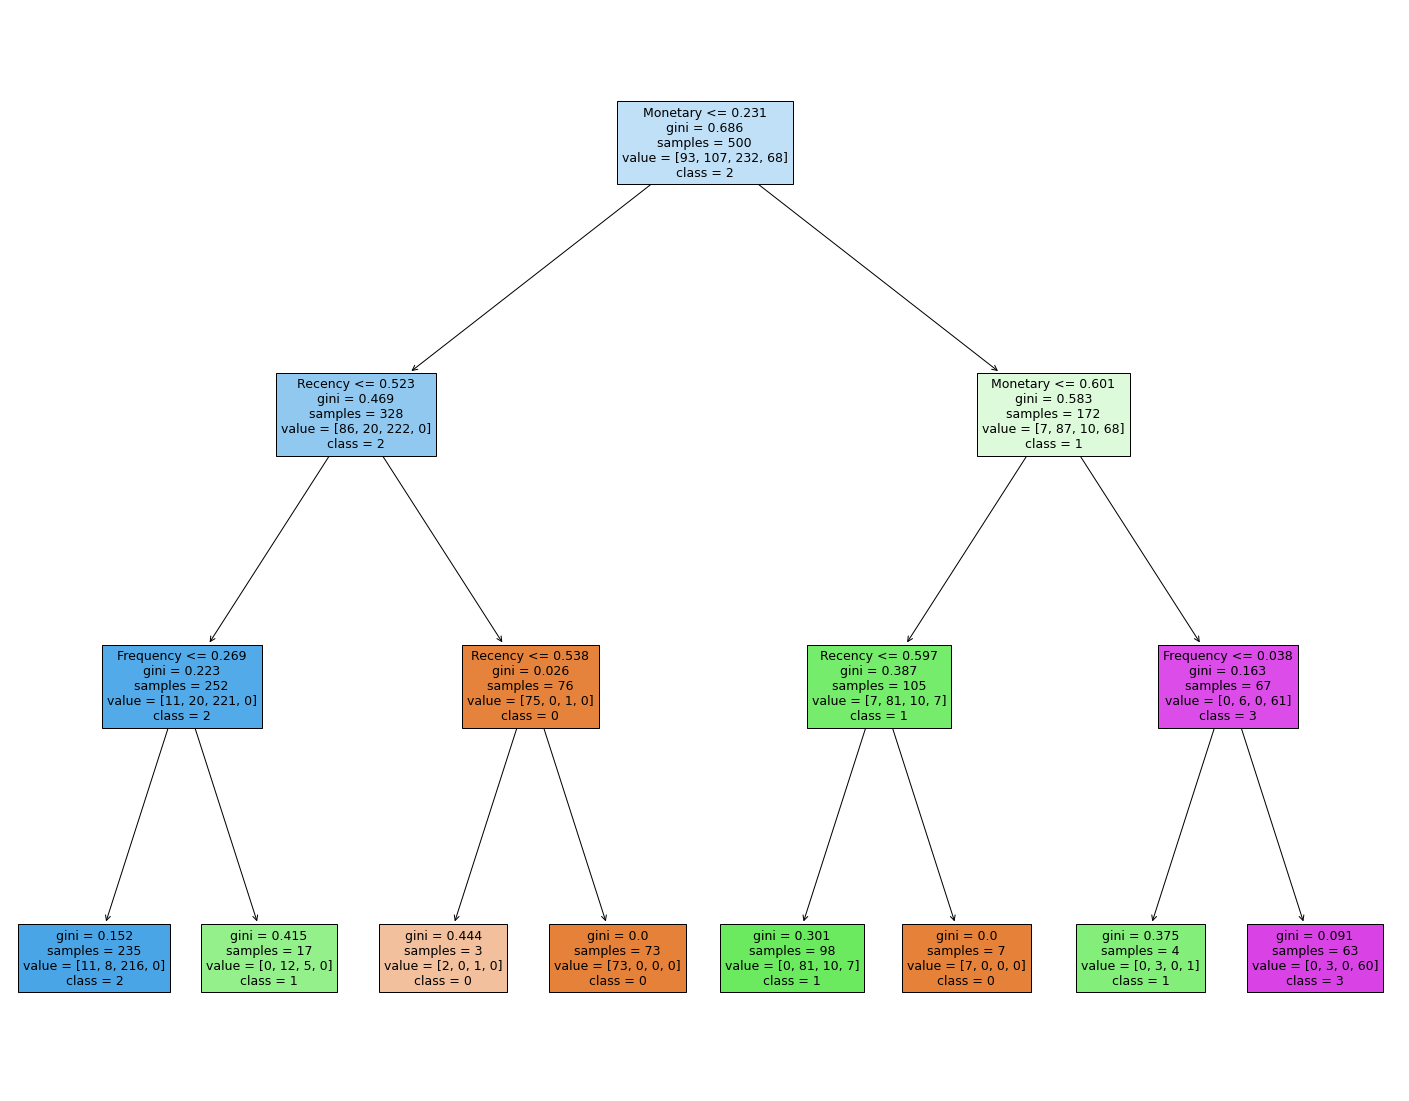

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=feature_names,  
                   class_names=['0','1','2','3'],
                   filled=True)

## K-means clustering

We can still perform K-means clustering if we delete a categorical variable from the data.

In [ ]:
data = data.drop(columns = ["Disabled","Employed","Medical leave","Retired", "Unemployed", "cluster"])

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(data)
data['cluster'] = kmeans.labels_

## K-means clustering interpretation

In [ ]:
feature_names = ['Income', 'Age', 'Monetary', 'Frequency', 'Recency']
y = ['cluster']

In [ ]:
model = DecisionTreeClassifier(random_state = 0, max_depth = 3) 
model.fit(data[feature_names], data[y]['cluster'])

DecisionTreeClassifier(max_depth=3, random_state=0)

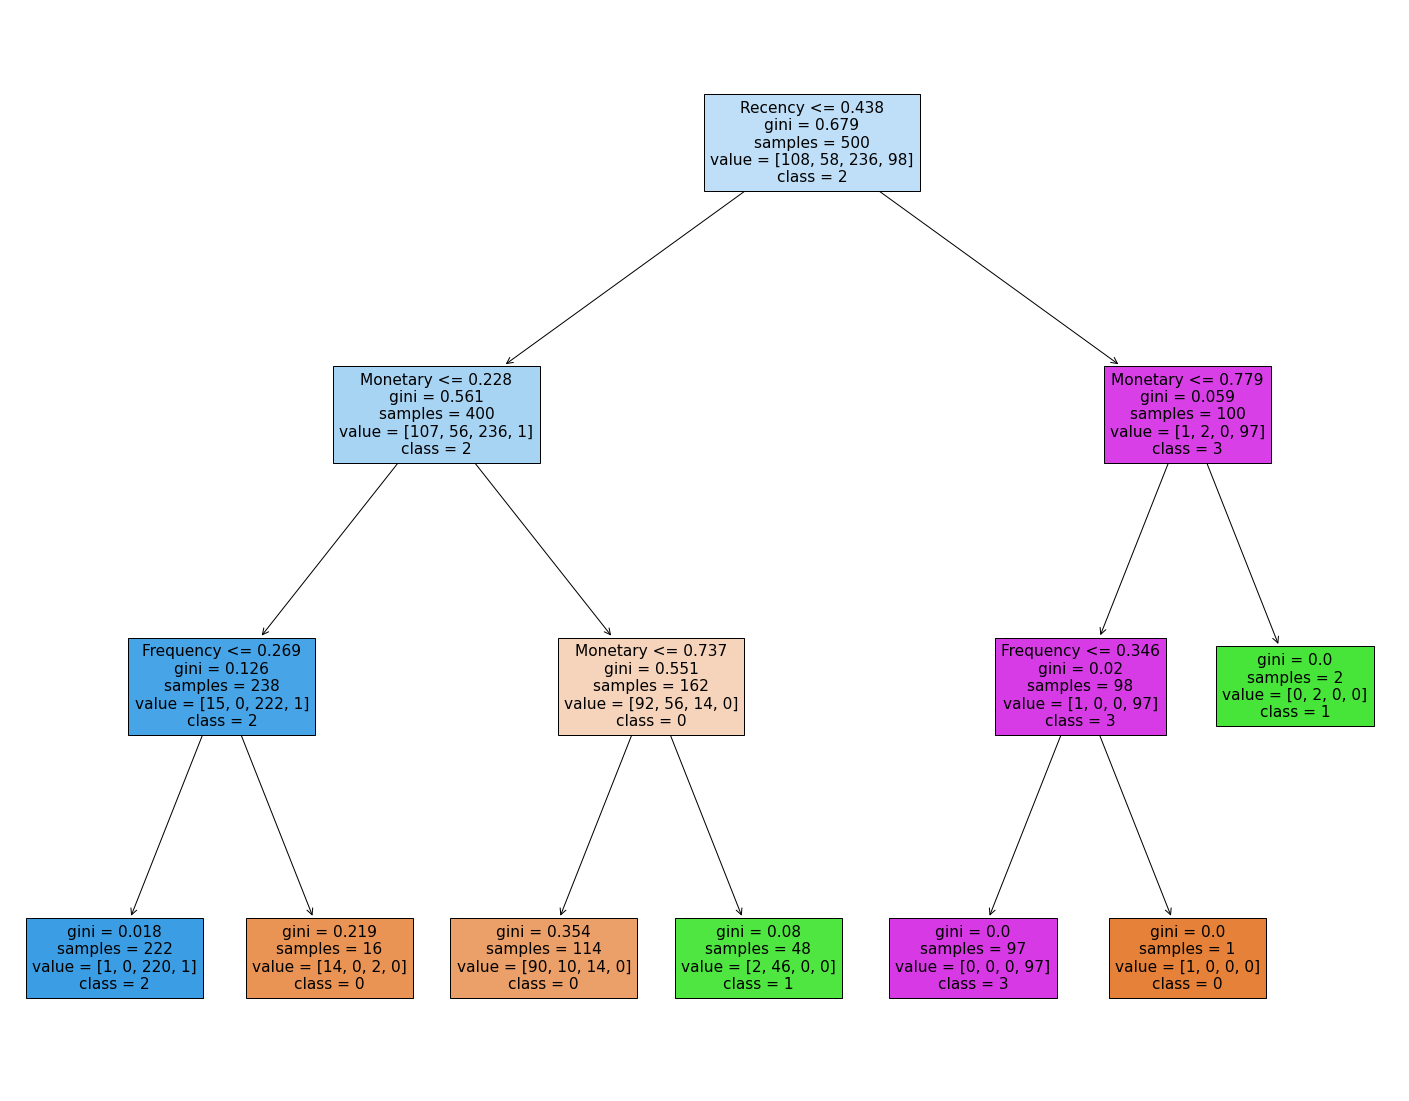

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=feature_names,  
                   class_names=['0','1','2','3'],
                   filled=True)